# Pipeline Rekognisi Wajah v5 (Final): Output Gambar Lengkap

**Tujuan Pipeline:**
Notebook ini menjalankan pipeline lengkap untuk pengenalan wajah dengan membandingkan dua jalur pemrosesan:

1.  **Jalur A (Baseline):** Pengenalan wajah langsung pada citra asli (probe).
2.  **Jalur B (Dengan Peningkatan):** Pengenalan wajah pada citra setelah melalui proses restorasi kualitas menggunakan GFPGAN.

Pipeline ini juga akan menghasilkan output visual yang lengkap, termasuk wajah yang terpotong, wajah yang telah direstorasi, dan gambar perbandingan, serta melakukan analisis statistik mendalam terhadap hasilnya.


### Langkah 1: Instalasi Pustaka yang Diperlukan


In [ ]:
# Pastikan semua pustaka yang dibutuhkan terinstal.
# gfpgan & facexlib: Untuk restorasi wajah.
# deepface: Untuk deteksi, alignment, dan rekognisi wajah.
# pyiqa: Untuk mengukur kualitas gambar (Image Quality Assessment) dengan metrik BRISQUE dan NIQE.
# scikit-learn, pandas, seaborn, matplotlib: Untuk analisis data dan visualisasi.
# %pip install gfpgan deepface facexlib tqdm pandas matplotlib scikit-learn seaborn pyiqa

### Langkah 2: Impor Pustaka & Konfigurasi Path


In [12]:
import os
import sys
import glob
import cv2
import numpy as np
import json
import time
import pickle
import torch
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from deepface import DeepFace
from gfpgan import GFPGANer
import pyiqa
from scipy.spatial.distance import cosine
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- Konfigurasi Path --- 
BASE_DIR = os.path.abspath('.')
PROJECT_ROOT = os.path.abspath(os.path.join(BASE_DIR, '..')) # Asumsi notebook ada di dalam subfolder proyek
GALLERY_PATH = os.path.join(BASE_DIR, 'data', 'gallery')
PROBES_PATH = os.path.join(BASE_DIR, 'data', 'probes')
RESULTS_PATH = os.path.join(BASE_DIR, 'results_v5')
CACHE_PATH = os.path.join(BASE_DIR, 'cache')

# --- Konfigurasi Path untuk Output Gambar ---
CROPPED_FACES_PATH = os.path.join(RESULTS_PATH, 'cropped_faces')
RESTORED_FACES_PATH = os.path.join(RESULTS_PATH, 'restored_faces')
RESTORED_IMGS_PATH = os.path.join(RESULTS_PATH, 'restored_imgs')
COMPARISON_PATH = os.path.join(RESULTS_PATH, 'cmp')

# --- Path File Cache ---
EMBEDDING_CACHE_FILE = os.path.join(CACHE_PATH, 'embedding_cache.pkl')

# Pastikan semua direktori output ada, jika tidak maka buat direktori baru.
for path in [RESULTS_PATH, CACHE_PATH, CROPPED_FACES_PATH, RESTORED_FACES_PATH, RESTORED_IMGS_PATH, COMPARISON_PATH]:
    os.makedirs(path, exist_ok=True)

print(f"Notebook berjalan di direktori: {BASE_DIR}")
print(f"Hasil akan disimpan di: {RESULTS_PATH}")

Notebook berjalan di direktori: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi
Hasil akan disimpan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v5


### Langkah 3: Inisialisasi Model-Model Utama

Tahap ini memuat semua model yang diperlukan ke dalam memori (CPU atau GPU). Ini termasuk:

- **GFPGAN**: Untuk restorasi wajah.
- **pyiqa (BRISQUE & NIQE)**: Untuk penilaian kualitas gambar.
- **DeepFace (ArcFace)**: Untuk ekstraksi fitur (embedding) wajah. Dilakukan _warm-up_ agar pemrosesan pertama tidak lambat.


In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Menggunakan device: {DEVICE}')

# Inisialisasi GFPGAN Restorer
print("Memuat model GFPGAN v1.4...")
gfpgan_model_path = os.path.join(PROJECT_ROOT, 'model_gfpgan', 'gfpgan', 'weights', 'GFPGANv1.4.pth')
if not os.path.exists(gfpgan_model_path):
    print(f"ERROR: Model GFPGAN tidak ditemukan di {gfpgan_model_path}")
    # Anda bisa menambahkan sys.exit() di sini jika model tidak ada adalah kesalahan fatal
else:
    gfpgan_restorer = GFPGANer(
        model_path=gfpgan_model_path,
        upscale=2, # Skala pembesaran wajah yang direstorasi
        arch='clean',
        channel_multiplier=2,
        bg_upsampler=None, # Tidak melakukan upsampling pada background
        device=DEVICE
    )
    print("Model GFPGAN siap.")

# Inisialisasi IQA Assessors dari pyiqa
print("Memuat model BRISQUE (No-Reference IQA)...")
brisque_assessor = pyiqa.create_metric('brisque', device=DEVICE)
print("Model BRISQUE siap.")

print("Memuat model NIQE (No-Reference IQA)...")
niqe_assessor = pyiqa.create_metric('niqe', device=DEVICE)
print("Model NIQE siap.")

# Pre-load model DeepFace untuk 'warming up' agar inferensi pertama tidak lambat
print("Warm-up model DeepFace (ArcFace)...")
try:
    _ = DeepFace.represent(np.zeros((112, 112, 3), dtype=np.uint8), model_name='ArcFace', enforce_detection=False)
    print("Model DeepFace siap.")
except Exception as e:
    print(f"Gagal melakukan warm-up DeepFace: {e}")

Menggunakan device: cuda
Memuat model GFPGAN v1.4...
Model GFPGAN siap.
Memuat model BRISQUE (No-Reference IQA)...
Model BRISQUE siap.
Memuat model NIQE (No-Reference IQA)...
Model NIQE siap.
Warm-up model DeepFace (ArcFace)...
Model DeepFace siap.


### Langkah 4: Fungsi-Fungsi Utilitas


In [14]:
def parse_filename(filename: str) -> dict | None:
    """
    Mengekstrak metadata dari nama file probe sesuai format yang ditentukan.
    Format: 'subject_X_height_Y_distance_Z.JPG'
    
    Args:
        filename (str): Path atau nama file gambar.
    
    Returns:
        dict: Dictionary berisi metadata jika parsing berhasil, atau None jika gagal.
    """
    try:
        base_name = os.path.basename(filename)
        parts = os.path.splitext(base_name)[0].split('_')
        if len(parts) < 5: return None

        subject_id, height_id, distance_id = parts[0], parts[2], parts[4]
        if height_id == 'na' or distance_id == 'na': return None

        distance_val = int(distance_id)
        distance_m = 17 - (distance_val / 2)
        
        if distance_val > 24: 
            distance_category = 'dekat'
        elif 14 <= distance_val <= 24: 
            distance_category = 'menengah'
        else: 
            distance_category = 'jauh'

        height_map = {'3': 'rendah', '5': 'tinggi'}
        height_category = height_map.get(height_id)
        if not height_category: return None

        return {
            'subject_id': subject_id,
            'distance_m': distance_m,
            'distance_category': distance_category,
            'height_id': height_id,
            'height_category': height_category
        }
    except (IndexError, ValueError):
        # Gagal parsing karena format nama file salah atau nilai tidak valid
        return None

def get_embedding(image_path_or_array, model_name='ArcFace', detector_backend='retinaface') -> list | None:
    """
    Menghasilkan vektor embedding wajah dari sebuah gambar.

    Args:
        image_path_or_array: Path file gambar atau array numpy BGR.
        model_name (str): Model yang digunakan untuk rekognisi.
        detector_backend (str): Model yang digunakan untuk deteksi wajah.

    Returns:
        list: Vektor embedding jika wajah terdeteksi, atau None jika tidak.
    """
    try:
        embedding_objs = DeepFace.represent(
            img_path=image_path_or_array,
            model_name=model_name,
            enforce_detection=True, # Memastikan wajah terdeteksi
            detector_backend=detector_backend
        )
        # Ambil embedding dari wajah pertama yang terdeteksi
        return embedding_objs[0]['embedding']
    except (ValueError, AttributeError, IndexError, TypeError):
        # ValueError sering muncul jika DeepFace tidak menemukan wajah
        return None

def find_best_match(probe_embedding: list, gallery_embeddings: dict) -> tuple[str | None, float]:
    """
    Mencari subjek di galeri yang paling cocok dengan embedding probe.

    Args:
        probe_embedding (list): Vektor embedding dari gambar probe.
        gallery_embeddings (dict): Dictionary {subject_id: embedding} dari galeri.

    Returns:
        tuple: (subject_id terbaik, jarak kosinus minimum).
    """
    if probe_embedding is None or not gallery_embeddings:
        return None, float('inf')
    
    best_match_id = None
    min_dist = float('inf')
    
    for subject_id, gallery_embedding in gallery_embeddings.items():
        if gallery_embedding is None: continue
        dist = cosine(probe_embedding, gallery_embedding)
        if dist < min_dist:
            min_dist = dist
            best_match_id = subject_id
            
    return best_match_id, min_dist

def get_iqa_score(image_array, assessor):
    # Cek jika image_array valid (tidak None dan tidak kosong)
    if image_array is None or image_array.size == 0:
        return None
    try:
        # Konversi BGR (OpenCV) ke RGB, lalu ke Tensor [0,1] C,H,W
        img_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0) / 255.0
        score = assessor(img_tensor.to(DEVICE)).item()
        return score
    except Exception as e:
        return None

print("Fungsi utilitas siap digunakan.")

Fungsi utilitas siap digunakan.


### Langkah 5: Pembuatan Galeri Referensi

Proses ini mengekstrak fitur (embedding) dari setiap gambar di folder galeri. Hasilnya disimpan dalam sebuah dictionary `gallery_embeddings`, yang akan menjadi database referensi untuk pencocokan.


In [15]:
gallery_embeddings = {}
gallery_files = glob.glob(os.path.join(GALLERY_PATH, '*.jpg'))

if not gallery_files:
    print(f"PERINGATAN: Tidak ada gambar ditemukan di folder galeri: {GALLERY_PATH}")
else:
    print(f"Membuat database fitur dari {len(gallery_files)} gambar di galeri...")
    for g_file in tqdm(gallery_files, desc="Membangun Galeri"):
        subject_id = os.path.basename(g_file).split('_')[0]
        embedding = get_embedding(g_file)
        if embedding is not None:
            gallery_embeddings[subject_id] = embedding
        else:
            print(f"Gagal membuat embedding untuk file galeri: {g_file}")

    print(f"Database fitur galeri berhasil dibuat untuk {len(gallery_embeddings)} subjek: {list(gallery_embeddings.keys())}")

Membuat database fitur dari 11 gambar di galeri...


Membangun Galeri:   0%|          | 0/11 [00:00<?, ?it/s]

Database fitur galeri berhasil dibuat untuk 11 subjek: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']


### Langkah 6: Eksekusi Pipeline Utama (Versi 5 Final)

Ini adalah inti dari notebook. Setiap gambar _probe_ akan diproses melalui dua jalur (A dan B). Semua hasil, termasuk prediksi, status keberhasilan, dan skor kualitas gambar, akan disimpan dalam list `results_v5` dan kemudian diekspor ke file JSON.


In [16]:
# Muat cache embedding jika ada untuk mempercepat proses
try:
    with open(EMBEDDING_CACHE_FILE, 'rb') as f:
        embedding_cache = pickle.load(f)
    print(f"Berhasil memuat {len(embedding_cache)} embedding dari cache.")
except (FileNotFoundError, EOFError):
    embedding_cache = {}
    print("Cache embedding tidak ditemukan atau korup, akan membuat baru.")

probe_files = glob.glob(os.path.join(PROBES_PATH, '*.JPG'))
results_v5 = []

print(f"Memulai pemrosesan {len(probe_files)} citra uji...")
start_time = time.time()

for probe_path in tqdm(probe_files, desc="Memproses Probe"):
    metadata = parse_filename(probe_path)
    if not metadata:
        print(f"Skipping file dengan format nama salah: {os.path.basename(probe_path)}")
        continue

    probe_filename = os.path.basename(probe_path)
    ground_truth = metadata['subject_id']
    
    # --- Inisialisasi hasil untuk iterasi ini ---
    prediction_A, prediction_B = None, None
    is_correct_A, is_correct_B = False, False
    restoration_succeeded = False
    brisque_original, brisque_restored = None, None
    niqe_original, niqe_restored = None, None

    # --- Jalur A (Tanpa Restorasi) ---
    if probe_filename in embedding_cache:
        embedding_A = embedding_cache[probe_filename]
    else:
        embedding_A = get_embedding(probe_path)
        embedding_cache[probe_filename] = embedding_A
    
    if embedding_A is not None:
        prediction_A, _ = find_best_match(embedding_A, gallery_embeddings)
        if prediction_A == ground_truth:
            is_correct_A = True

    # --- Jalur B (Dengan Restorasi & Penyimpanan Gambar) ---
    try:
        img_original = cv2.imread(probe_path, cv2.IMREAD_COLOR)
        if img_original is None:
            print(f"Gagal membaca gambar: {probe_filename}")
            continue

        # Hitung IQA pada gambar asli (keseluruhan)
        brisque_original = get_iqa_score(img_original, brisque_assessor)
        niqe_original = get_iqa_score(img_original, niqe_assessor)
        
        # Lakukan restorasi dengan GFPGAN
        cropped_faces, restored_faces, restored_pasted_img = gfpgan_restorer.enhance(
            img_original, has_aligned=False, only_center_face=True)
        
        if restored_faces and restored_faces[0] is not None:
            original_cropped_face = cropped_faces[0]
            restored_face = restored_faces[0]
            restoration_succeeded = True

            # --- Menyimpan semua jenis gambar output ---
            cv2.imwrite(os.path.join(CROPPED_FACES_PATH, probe_filename), original_cropped_face)
            cv2.imwrite(os.path.join(RESTORED_FACES_PATH, probe_filename), restored_face)
            if restored_pasted_img is not None:
                cv2.imwrite(os.path.join(RESTORED_IMGS_PATH, probe_filename), restored_pasted_img)
            
            # --- Membuat dan menyimpan gambar komparasi ---
            try:
                h, w, _ = restored_face.shape
                # Resize wajah asli agar ukurannya sama dengan wajah restorasi untuk perbandingan
                upscaled_original = cv2.resize(original_cropped_face, (w, h), interpolation=cv2.INTER_CUBIC)
                comparison_image = np.concatenate((upscaled_original, restored_face), axis=1)
                cv2.imwrite(os.path.join(COMPARISON_PATH, probe_filename), comparison_image)
            except Exception as cmp_e:
                print(f"Gagal membuat gambar perbandingan untuk {probe_filename}: {cmp_e}")

            # --- Melanjutkan ke evaluasi pada wajah yang direstorasi ---
            brisque_restored = get_iqa_score(restored_face,brisque_assessor)
            niqe_restored = get_iqa_score(restored_face, niqe_assessor)
            
            embedding_B = get_embedding(restored_face)
            if embedding_B is not None:
                prediction_B, _ = find_best_match(embedding_B, gallery_embeddings)
                if prediction_B == ground_truth:
                    is_correct_B = True
    except Exception as e:
        print(f"Error saat memproses Jalur B untuk {probe_filename}: {e}")
        # Set nilai default jika terjadi error pada Jalur B
        is_correct_B = False
        restoration_succeeded = False

    results_v5.append({
        'file': probe_filename,
        'metadata': metadata,
        'ground_truth': ground_truth,
        'prediction_A': prediction_A,
        'is_correct_A': is_correct_A,
        'prediction_B': prediction_B,
        'is_correct_B': is_correct_B,
        'restoration_succeeded': restoration_succeeded,
        'brisque_original_img': brisque_original,
        'brisque_restored_face': brisque_restored,
        'niqe_original_img': niqe_original,
        'niqe_restored_face': niqe_restored
    })

# --- Simpan Hasil dan Cache ---
end_time = time.time()
print(f"\nSelesai memproses {len(results_v5)} citra uji dalam {end_time - start_time:.2f} detik.")

results_file_path = os.path.join(RESULTS_PATH, 'pipeline_results_v5.json')
with open(results_file_path, 'w') as f:
    json.dump(results_v5, f, indent=4)
print(f"Variabel 'results_v5' berhasil disimpan ke: {results_file_path}")

with open(EMBEDDING_CACHE_FILE, 'wb') as f:
    pickle.dump(embedding_cache, f)
print(f"Cache embedding berhasil disimpan ke: {EMBEDDING_CACHE_FILE}")

Cache embedding tidak ditemukan atau korup, akan membuat baru.
Memulai pemrosesan 1364 citra uji...


Memproses Probe:   0%|          | 0/1364 [00:00<?, ?it/s]

Skipping file dengan format nama salah: a_gp_0_ef_00.jpg
Skipping file dengan format nama salah: a_gp_0_ef_01.jpg
Skipping file dengan format nama salah: a_gp_0_ef_02.jpg
Skipping file dengan format nama salah: a_gp_0_ef_03.jpg
Skipping file dengan format nama salah: a_gp_0_ef_04.jpg
Skipping file dengan format nama salah: a_gp_0_ef_05.jpg
Skipping file dengan format nama salah: a_gp_0_ef_06.jpg
Skipping file dengan format nama salah: a_gp_0_ef_07.jpg
Skipping file dengan format nama salah: a_gp_0_ef_08.jpg
Skipping file dengan format nama salah: a_gp_0_ef_09.jpg
Skipping file dengan format nama salah: a_gp_0_ef_10.jpg
Skipping file dengan format nama salah: a_gp_0_ef_11.jpg
Skipping file dengan format nama salah: a_gp_0_ef_12.jpg
Skipping file dengan format nama salah: a_gp_0_ef_13.jpg
Skipping file dengan format nama salah: a_gp_0_ef_14.jpg
Skipping file dengan format nama salah: a_gp_0_ef_15.jpg
Skipping file dengan format nama salah: a_gp_0_ef_16.jpg
Skipping file dengan format nam

### Langkah 7: Analisis Hasil dan Visualisasi

Bagian ini memuat kembali hasil yang baru saja disimpan dalam format JSON ke dalam Pandas DataFrame untuk analisis yang lebih mudah. Metrik evaluasi akan dihitung dan berbagai visualisasi akan dibuat untuk mempermudah interpretasi hasil.


In [17]:
# Muat hasil dari file JSON untuk analisis
results_file_path = os.path.join(RESULTS_PATH, 'pipeline_results_v5.json')
try:
    with open(results_file_path, 'r') as f:
        results_data = json.load(f)
except FileNotFoundError:
    print(f"File hasil tidak ditemukan: {results_file_path}. Jalankan Langkah 6 terlebih dahulu.")
    # Hentikan eksekusi sel ini jika file tidak ada
    df = pd.DataFrame()
else:
    df = pd.DataFrame(results_data)
    # Konversi kolom 'metadata' yang berisi dictionary menjadi beberapa kolom terpisah
    df_meta = pd.json_normalize(df['metadata'])
    df = pd.concat([df.drop('metadata', axis=1), df_meta], axis=1)

if not df.empty:
    print(f"Data hasil berhasil dimuat. Total {len(df)} baris.")
    display(df.head())
else:
    print("DataFrame kosong, analisis tidak dapat dilanjutkan.")

Data hasil berhasil dimuat. Total 682 baris.


,file,ground_truth,prediction_A,is_correct_A,prediction_B,is_correct_B,restoration_succeeded,brisque_original_img,brisque_restored_face,niqe_original_img,niqe_restored_face,subject_id,distance_m,distance_category,height_id,height_category
0,a_gp_3_ef_00.jpg,a,k,False,None,False,False,92.569397,NaN,NaN,NaN,a,17.0,jauh,3,rendah
1,a_gp_3_ef_01.jpg,a,k,False,None,False,False,45.396423,NaN,NaN,NaN,a,16.5,jauh,3,rendah
2,a_gp_3_ef_02.jpg,a,k,False,a,True,True,44.992859,-7.148254,NaN,4.866939,a,16.0,jauh,3,rendah
3,a_gp_3_ef_03.jpg,a,k,False,a,True,True,36.955261,-4.053040,NaN,5.237239,a,15.5,jauh,3,rendah
4,a_gp_3_ef_04.jpg,a,k,False,a,True,True,44.900574,-1.363586,NaN,4.996797,a,15.0,jauh,3,rendah


#### 7.1 Analisis Performa Keseluruhan


In [19]:
def create_summary_table(df: pd.DataFrame, group_by_col: str) -> pd.DataFrame:
    """
    Membuat tabel ringkasan performa yang dikelompokkan berdasarkan kolom tertentu.
    
    Args:
        df (pd.DataFrame): DataFrame hasil eksperimen.
        group_by_col (str): Nama kolom untuk pengelompokan (misal, 'distance_category').
    
    Returns:
        pd.DataFrame: Tabel ringkasan performa.
    """
    summary_list = []
    # Pastikan urutan kategori logis
    categories = sorted(df[group_by_col].unique())

    for category in categories:
        subset_df = df[df[group_by_col] == category]
        count = len(subset_df)
        if count == 0: continue

        # Metrik Jalur A (Tanpa Restorasi)
        accuracy_A = subset_df['is_correct_A'].mean()
        
        # Metrik Jalur B (Dengan Restorasi)
        accuracy_B = subset_df['is_correct_B'].mean()
        
        # Peningkatan Akurasi
        if accuracy_A > 0:
            improvement = ((accuracy_B - accuracy_A) / accuracy_A)
            improvement_str = f'{improvement:+.2%}'
        elif accuracy_B > 0:
            improvement_str = '∞' # Peningkatan tak terhingga dari 0
        else:
            improvement_str = 'N/A'
        
        summary_list.append({
            'Kategori': category,
            'Jumlah Sampel': count,
            'Akurasi (Jalur A)': f'{accuracy_A:.2%}',
            'Akurasi (Jalur B)': f'{accuracy_B:.2%}',
            'Peningkatan Akurasi': improvement_str
        })
    
    return pd.DataFrame(summary_list).set_index('Kategori')

if not df.empty:
    # Analisis berdasarkan Jarak
    summary_distance = create_summary_table(df, 'distance_category')
    print("--- Analisis Berdasarkan Jarak ---")
    display(summary_distance.reindex(['dekat', 'menengah', 'jauh']))

    # Analisis berdasarkan Ketinggian
    summary_height = create_summary_table(df, 'height_category')
    print("\n--- Analisis Berdasarkan Ketinggian ---")
    display(summary_height.reindex(['rendah', 'tinggi']))

--- Analisis Berdasarkan Jarak ---


,Jumlah Sampel,Akurasi (Jalur A),Akurasi (Jalur B),Peningkatan Akurasi
Kategori,,,,
dekat,132,65.15%,68.94%,+5.81%
menengah,242,65.29%,73.14%,+12.03%
jauh,308,15.26%,31.17%,+104.26%



--- Analisis Berdasarkan Ketinggian ---


,Jumlah Sampel,Akurasi (Jalur A),Akurasi (Jalur B),Peningkatan Akurasi
Kategori,,,,
rendah,341,54.55%,61.29%,+12.37%
tinggi,341,30.79%,45.45%,+47.62%


#### 7.2 Analisis Kualitas Gambar (BRISQUE & NIQE)

Analisis ini membandingkan skor kualitas gambar sebelum dan sesudah restorasi. **Catatan Penting:** Untuk metrik BRISQUE dan NIQE, **skor yang lebih rendah menunjukkan kualitas yang lebih baik**.


--- Analisis Rata-Rata Kualitas Gambar (BRISQUE & NIQE) ---
Rata-rata BRISQUE (Gambar Asli): 32.17 (Lebih tinggi = kualitas lebih rendah)
Rata-rata BRISQUE (Wajah Restorasi): 3.96 (Lebih rendah = kualitas lebih baik)
---
Rata-rata NIQE (Gambar Asli): 8.08 (Lebih tinggi = kualitas lebih rendah)
Rata-rata NIQE (Wajah Restorasi): 5.16 (Lebih rendah = kualitas lebih baik)


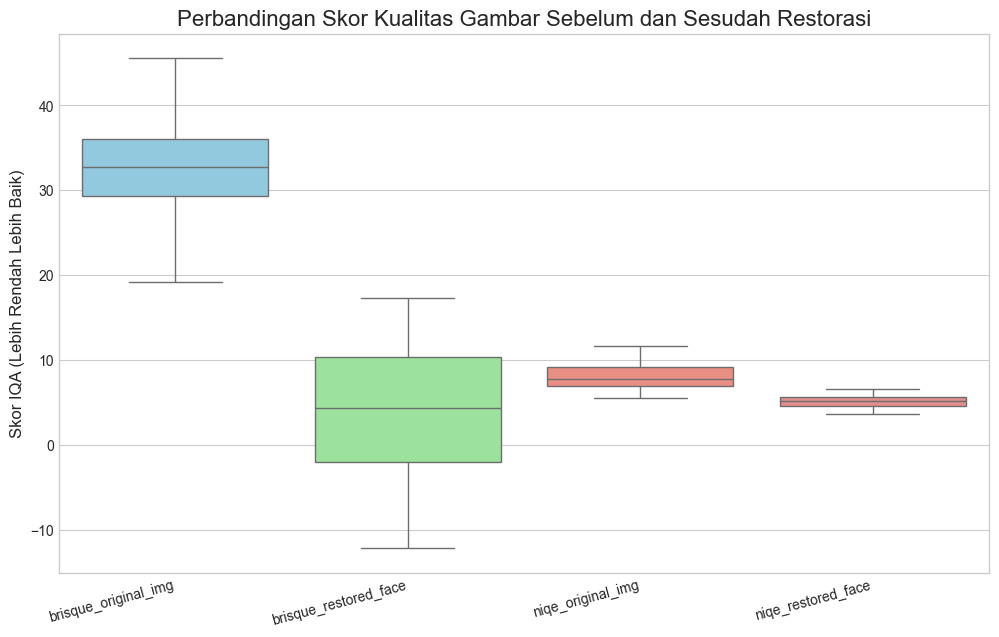

Grafik perbandingan IQA disimpan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v5\iqa_comparison_v5.png


In [21]:
if not df.empty:
    # Pilih kolom IQA dan hapus baris di mana restorasi gagal (nilai NaN)
    iqa_df = df[['brisque_original_img', 'brisque_restored_face', 'niqe_original_img', 'niqe_restored_face']].copy()
    iqa_df.dropna(inplace=True)
    
    if not iqa_df.empty:
        avg_brisque_original = iqa_df['brisque_original_img'].mean()
        avg_brisque_restored = iqa_df['brisque_restored_face'].mean()
        avg_niqe_original = iqa_df['niqe_original_img'].mean()
        avg_niqe_restored = iqa_df['niqe_restored_face'].mean()

        print("--- Analisis Rata-Rata Kualitas Gambar (BRISQUE & NIQE) ---")
        print(f"Rata-rata BRISQUE (Gambar Asli): {avg_brisque_original:.2f} (Lebih tinggi = kualitas lebih rendah)")
        print(f"Rata-rata BRISQUE (Wajah Restorasi): {avg_brisque_restored:.2f} (Lebih rendah = kualitas lebih baik)")
        print('---')
        print(f"Rata-rata NIQE (Gambar Asli): {avg_niqe_original:.2f} (Lebih tinggi = kualitas lebih rendah)")
        print(f"Rata-rata NIQE (Wajah Restorasi): {avg_niqe_restored:.2f} (Lebih rendah = kualitas lebih baik)")

        # Visualisasi dengan Box Plot
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(12, 7))
        sns.boxplot(data=iqa_df, palette=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
        plt.title('Perbandingan Skor Kualitas Gambar Sebelum dan Sesudah Restorasi', fontsize=16)
        plt.ylabel('Skor IQA (Lebih Rendah Lebih Baik)', fontsize=12)
        plt.xticks(rotation=15, ha='right')
        
        iqa_chart_path = os.path.join(RESULTS_PATH, 'iqa_comparison_v5.png')
        plt.savefig(iqa_chart_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Grafik perbandingan IQA disimpan di: {iqa_chart_path}")
    else:
        print("Tidak ada data IQA yang valid untuk dianalisis.")

#### 7.3 Confusion Matrix

Confusion matrix membantu kita melihat secara detail bagaimana model mengklasifikasikan setiap subjek. Kita bisa melihat subjek mana yang sering salah diklasifikasikan dan tertukar dengan subjek lain.


Confusion Matrix untuk Jalur A disimpan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v5\confusion_matrix_A_v5.png


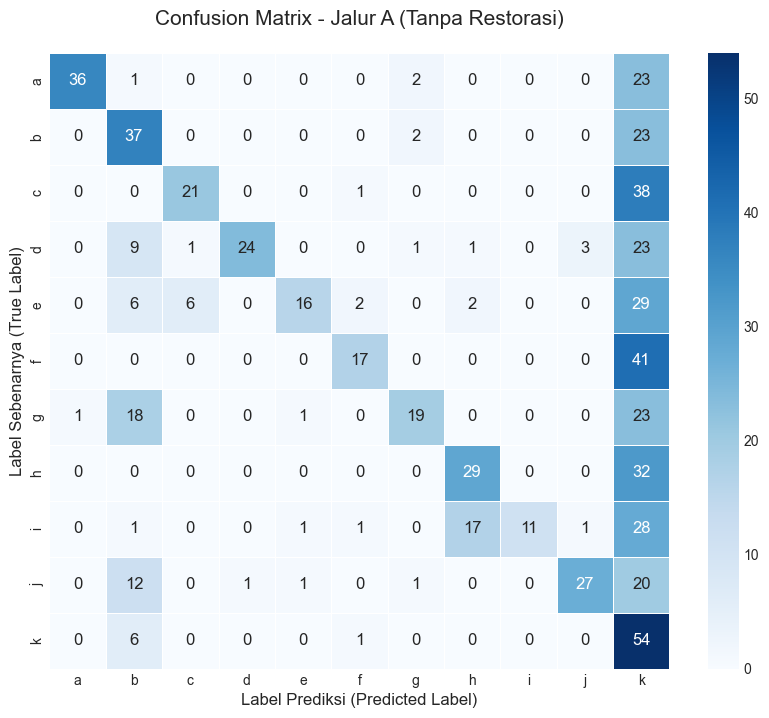

Confusion Matrix untuk Jalur B disimpan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v5\confusion_matrix_B_v5.png


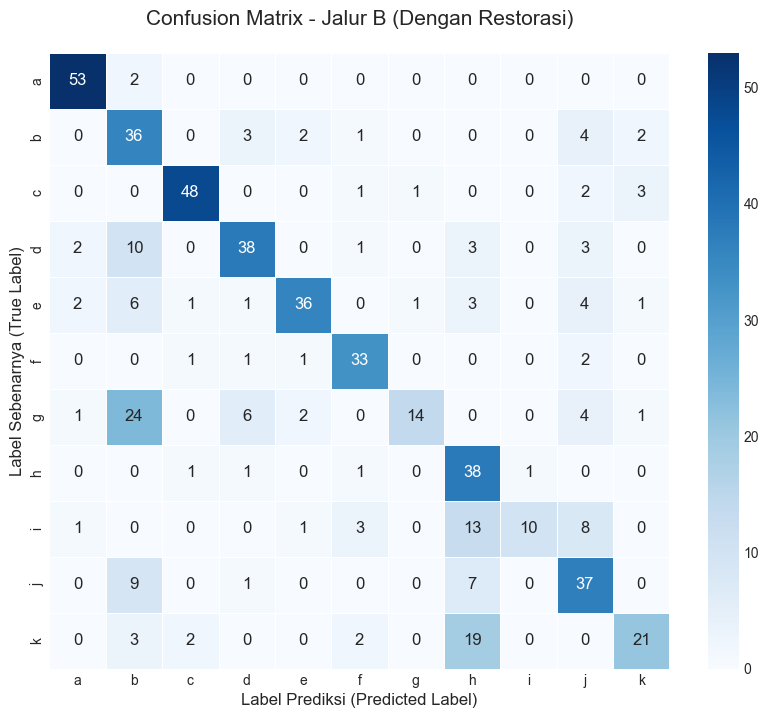

In [22]:
def plot_confusion_matrix_v2(df: pd.DataFrame, pipeline_type: str, labels: list):
    """
    Membuat dan menampilkan confusion matrix untuk pipeline A atau B.
    
    Args:
        df (pd.DataFrame): DataFrame hasil.
        pipeline_type (str): 'A' untuk tanpa restorasi, 'B' untuk dengan restorasi.
        labels (list): Daftar unik label/subjek.
    """
    if pipeline_type == 'A':
        title = 'Confusion Matrix - Jalur A (Tanpa Restorasi)'
        pred_key = 'prediction_A'
    else:
        title = 'Confusion Matrix - Jalur B (Dengan Restorasi)'
        pred_key = 'prediction_B'
    
    # Filter data yang valid untuk matriks (ground truth dan prediksi tidak boleh NaN)
    cm_df = df.dropna(subset=['ground_truth', pred_key])
    if cm_df.empty:
        print(f"Tidak ada data valid untuk membuat Confusion Matrix Jalur {pipeline_type}.")
        return
        
    y_true = cm_df['ground_truth']
    y_pred = cm_df[pred_key]
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, linewidths=.5, annot_kws={"size": 12})
    plt.title(title, fontsize=15, pad=20)
    plt.ylabel('Label Sebenarnya (True Label)', fontsize=12)
    plt.xlabel('Label Prediksi (Predicted Label)', fontsize=12)
    
    file_path = os.path.join(RESULTS_PATH, f'confusion_matrix_{pipeline_type}_v5.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Confusion Matrix untuk Jalur {pipeline_type} disimpan di: {file_path}")
    plt.show()

if not df.empty:
    unique_labels = sorted(df['ground_truth'].unique())
    if unique_labels:
        plot_confusion_matrix_v2(df, 'A', unique_labels)
        plot_confusion_matrix_v2(df, 'B', unique_labels)
    else:
        print("Tidak ada label ground truth yang unik ditemukan.")

#### 7.4 Laporan Klasifikasi per Subjek

Laporan ini memberikan metrik _precision_, _recall_, dan _f1-score_ untuk setiap subjek. Ini berguna untuk mengevaluasi performa model pada tingkat individu, bukan hanya secara agregat.


In [23]:
if not df.empty:
    unique_labels = sorted(df['ground_truth'].unique())
    if unique_labels:
        # --- Laporan untuk Jalur A ---
        report_A_df = df.dropna(subset=['ground_truth', 'prediction_A'])
        if not report_A_df.empty:
            print("--- Laporan Klasifikasi Jalur A (Tanpa Restorasi) ---")
            report_A = classification_report(report_A_df['ground_truth'], report_A_df['prediction_A'], labels=unique_labels, zero_division=0)
            print(report_A)
        
        # --- Laporan untuk Jalur B ---
        report_B_df = df.dropna(subset=['ground_truth', 'prediction_B'])
        if not report_B_df.empty:
            print("\n--- Laporan Klasifikasi Jalur B (Dengan Restorasi) ---")
            report_B = classification_report(report_B_df['ground_truth'], report_B_df['prediction_B'], labels=unique_labels, zero_division=0)
            print(report_B)
    else:
        print("Tidak ada label untuk membuat laporan klasifikasi.")

--- Laporan Klasifikasi Jalur A (Tanpa Restorasi) ---
              precision    recall  f1-score   support

           a       0.97      0.58      0.73        62
           b       0.41      0.60      0.49        62
           c       0.75      0.35      0.48        60
           d       0.96      0.39      0.55        62
           e       0.84      0.26      0.40        61
           f       0.77      0.29      0.42        58
           g       0.76      0.31      0.44        62
           h       0.59      0.48      0.53        61
           i       1.00      0.18      0.31        60
           j       0.87      0.44      0.58        62
           k       0.16      0.89      0.27        61

    accuracy                           0.43       671
   macro avg       0.74      0.43      0.47       671
weighted avg       0.74      0.43      0.47       671


--- Laporan Klasifikasi Jalur B (Dengan Restorasi) ---
              precision    recall  f1-score   support

           a       0.9